## Multivariate Time Series forecast using seq2seq in TensorFlow

Based on 

weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/

Note use of Tensorflow - created a new virtualenv for this folder


In [1]:
import os
import copy
import random
import math

import numpy as np 
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

ImportError: Traceback (most recent call last):
  File "/home/walle/.virtualenvs/tf_py36/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/walle/.virtualenvs/tf_py36/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/walle/.virtualenvs/tf_py36/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/walle/.virtualenvs/tf_py36/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/walle/.virtualenvs/tf_py36/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcudnn.so.7: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

## Data exploration

In [ ]:
df = pd.read_csv(f'../input/merged_data/hh_melted_date_all_deltas.csv')

print(df.head())



In [ ]:
cols_to_plot = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
i = 1
# plot each column
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

## Preprocessing - there are many other ways

In [238]:
## Fill NA with 0 
#print(df.isnull().sum())
df.fillna(0, inplace = True)

## One-hot encode 'cbwd'
temp = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df, temp], axis = 1)
del df['cbwd'], temp

## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
df_train = df.iloc[:(-31*24), :].copy()
df_test = df.iloc[-31*24:, :].copy()

## take out the useful columns for modeling - you may also keep 'hour', 'day' or 'month' and to see if that will improve your accuracy
X_train = df_train.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
X_test = df_test.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
y_train = df_train['pm2.5'].values.copy().reshape(-1, 1)
y_test = df_test['pm2.5'].values.copy().reshape(-1, 1)

## z-score transform x - not including those one-how columns!
for i in range(X_train.shape[1]-4):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [243]:
input_seq_len = 30
output_seq_len = 5

def generate_train_samples(x = X_train, y = y_train, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq # in shape: (batch_size, time_steps, feature_dim)

def generate_test_samples(x = X_test, y = y_test, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    
    total_samples = x.shape[0]
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq

In [244]:
x, y = generate_train_samples()
print(x.shape, y.shape)

(10, 30, 11) (10, 5, 1)


In [245]:
test_x, test_y = generate_test_samples()
print(test_x.shape, test_y.shape)

(709, 30, 11) (709, 5, 1)


## Building the model - same multi-variate graph

In [246]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import tensorflow as tf
import copy
import os

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = input_seq_len
# length of output signals
output_seq_len = output_seq_len
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = X_train.shape[1]
# num of output signals
output_dim = y_train.shape[1]
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
        
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

## Train the model 

In [247]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
12.7415
49.3645
11.9952
19.3026
2.27891
10.0695
6.88179
1.61318
3.43801
1.48012
2.08897
2.23086
1.14729
1.24911
1.19186
0.825225
1.39854
0.83422
0.993482
1.15438
0.91724
0.449349
0.342243
0.773666
3.1517
0.742146
0.726734
0.693751
0.72849
3.75605
0.781623
0.435807
0.638508
0.323507
0.731374
5.73397
0.957414
0.566127
1.117
1.61221
1.45885
0.476478
0.395423
0.386837
0.668713
0.498765
0.371423
0.292672
0.759234
1.33207
0.278139
0.709335
2.95788
0.376149
0.526011
0.525355
0.908295
0.91461
0.275369
0.94319
0.355082
0.270793
3.21877
0.470822
0.27784
0.51771
0.296252
0.485652
0.387177
0.234737
0.528883
0.464315
0.873771
0.320562
0.398915
0.18107
0.317256
0.642497
0.332196
0.340152
0.374909
0.248349
0.421241
0.195085
0.984978
0.277065
0.240515
0.463023
0.624892
0.475202
0.643531
0.551283
0.176235
0.770045
0.35904
0.224581
0.498367
0.342903
0.263045
0.169285
Checkpoint saved at:  ./multivariate_ts_pollution_case


## Inference on test 
Notice the batch prediction which is different to previous

In [248]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./multivariate_ts_pollution_case
Test mse is:  0.336378205965


In [312]:
## remove duplicate hours and concatenate into one long array
test_y_expand = np.concatenate([test_y[i].reshape(-1) for i in range(0, test_y.shape[0], 5)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i].reshape(-1) for i in range(0, final_preds.shape[0], 5)], axis = 0)

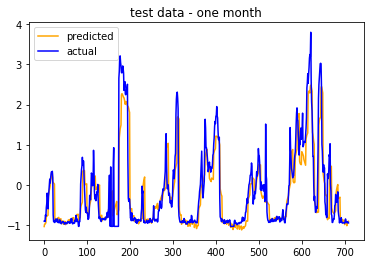

In [258]:
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()